In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
import pandas
mercer = pandas.ExcelFile('../anno/mercer.Supplemental_TableS1.xlsx')

In [7]:
print mercer.sheet_names
support = mercer.parse('Split-Invert Alignment')
supp = {}
for chrom, pos, strand in zip(support['Chromosome'], support['Start'], support['Strand']):
    if chrom not in supp: supp[chrom] = {}
    supp[chrom][pos] = 1

[u'Match Only', u'Match+Error', u'Match+Insertion', u'Match+Deletion', u'Split-Invert Alignment']


In [8]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, supp, phastcons, phylop):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            assert int(bp) in supp[chrom]
            if strand == '+':
                bp = L + bp - three
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
            
        for i in range(L-2):
            if strand == '+':
                coord = three - L + i
            else:
                coord = L - i + three - 1
            if (not _y[i]) and (coord in supp[chrom]):
                _y[i] = -1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, coords, strands = encode(known, supp, phastcons, phylop)

coords = coords[chroms == 'chr1']
strands = strands[chroms == 'chr1']
print np.sum(y == 1)
print np.sum(y == -1)
print X.shape

56808
35610
(37110, 70, 6)


In [9]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 6) (7093, 70, 6) (4306, 70, 6)
(25711, 70) (7093, 70) (4306, 70)


# Baseline models

In [10]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Conservation Meta

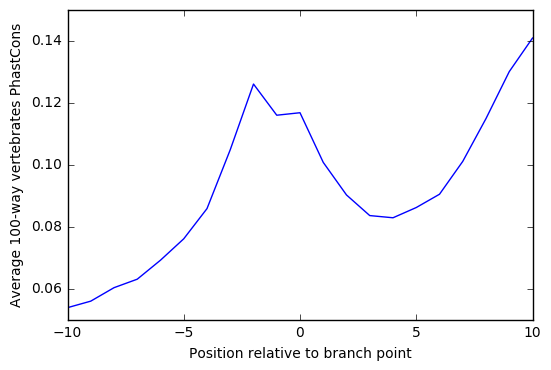

In [11]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(range(-K, K+1), counts / total)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhastCons')
plt.show()

# Dist Model

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    22.    25.    37.    41.    39.    47.    41.    47.    61.    77.
    82.    81.    92.    93.   140.   146.   185.   212.   230.   273.
   299.   386.   434.   497.   620.   735.   877.  1053.  1255.  1486.
  1770.  2073.  2261.  2496.  2712.  2872.  2790.  2860.  2567.  2140.
  1676.  1191.   775.   401.   258.   160.    96.    94.    71.    42.
    30.    24.    28.    30.    21.     0.     0.     0.     0.     0.]


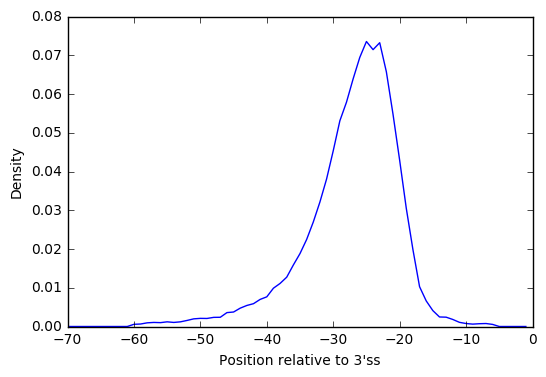

In [12]:
counts = np.zeros((L,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        counts[bp] += 1
        total += 1
print counts
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

In [13]:
def dist_pred(X, dists):
    return np.vstack([dists.T] * X.shape[0])

print matching(dist_pred(X_test, dists), y_test)
print matching(dist_pred(X_train, dists), y_train)

(620, 4306)
(4161, 25711)


# PWM model

In [14]:
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm = counts / total

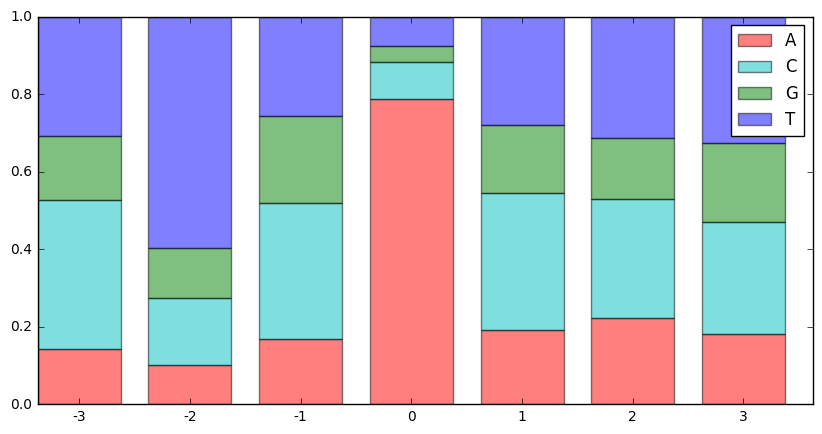

In [15]:
def pwm_logo(pwm, title = ''):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
pwm_logo(pwm)

In [16]:
def pwm_pred(X, pwm):
    scores = []
    for seq in X:
        s = [0] * K
        for i in range(seq.shape[0] - K*2):
            s += [np.sum(seq[i:i+2*K+1, :4] * pwm)]
        s += [0] * K
        scores += [np.array(s)]
    return np.vstack(scores)

print matching(pwm_pred(X_test, pwm), y_test)
print matching(pwm_pred(X_train, pwm), y_train)

(1740, 4306)
(9875, 25711)


# Load model

In [17]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [18]:
train_preds = model.predict(X_train[:, :, :4]).reshape(-1, 70)
valid_preds = model.predict(X_valid[:, :, :4]).reshape(-1, 70)
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)

# Model Performance

In [19]:
# Block Mercer 2016 training set
train_set = {}
with open('../anno/test_train_sites.csv') as fp:
    print fp.readline().strip()
    for line in fp:
        _, group, chrom, strand, pos, conf = line.strip().split(',')
        if conf != 'HC': continue
        if group != 'train': continue
        pos = int(pos)
        if chrom not in train_set: train_set[chrom] = set()
        train_set[chrom].add(pos)

id,testtrain,chromosome,strand,site,set


In [20]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, low_match, low_shifted, shifted = 0, 0, 0, 0, 0
    for p, t in zip(preds, true):
        if not np.sum(t==1): continue
        bp = np.argmax(p)
        if bp in np.array(range(L))[t == 1]:
            match += 1
        elif any(i in np.array(range(L))[t == 1]
                 for i in range(bp-E, bp+B+1)):
            shifted += 1
        ### above is high conf, below is low conf
        if bp in np.array(range(L))[t != 0]:
            low_match += 1
        elif any(i in np.array(range(L))[t != 0]
                 for i in range(bp-E, bp+B+1)):
            low_shifted += 1
            
        total += 1
    heights = [match / float(total),  low_match / float(total),
               (match+shifted) / float(total),
               (low_match+low_shifted) / float(total),
              ]
    index = [0, .15, .3, .45]
    plt.bar(index, heights, .1, align = 'center', alpha = 0.5)
    plt.ylim(0, 1)
    plt.xticks(index, ['High Conf',
                       'Low Conf',
                       '<4 High',
                       '<4 Low'])
    plt.yticks(heights, map(lambda x: "{}%".format(int(x * 100)), heights))
    plt.ylabel("Highest scoring branchpoint for 3'ss")
    plt.title(title)
    plt.show()
    return total, heights

In [31]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=-.1-xlim,
                        right=.1+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

def plt_aspect(aspect):
    fig = plt.figure()
    adjustFigAspect(fig,aspect=aspect)
    return fig.add_subplot(111)

def performance(lstm_h, bptr_h, totals, labels, title):
    step = .1
    sig_x, sig_y = [], []
    idx = np.linspace(0, step * len(labels), len(labels))
    for i, label in enumerate(labels):
        odds, pvalue =  fisher_exact([[lstm_h[i]*totals[i],
                                       totals[i]-lstm_h[i]*totals[i]],
                                      [bptr_h[i]*totals[i],
                                       totals[i]-bptr_h[i]*totals[i]]],
                                     'greater')
        print pvalue
        if pvalue < .05:
            sig_x += [idx[i]]
            sig_y += [.02+max(lstm_h[i], bptr_h[i])]
            
    plt_aspect(1.5)
            
    
    plt.scatter(sig_x, sig_y, marker = '*')
    plt.bar(idx-step/4,
            lstm_h, step/2.0, align = 'center', alpha = 0.5,  color = 'green', label = 'LaBranchoR')
    plt.bar(idx+step/4,
            bptr_h, step/2.0, align = 'center', alpha = 0.5, label = 'Branchpointer')
    plt.xlim(0-step/1.5, step * len(labels) + step/1.5)
    plt.ylim(0, 1)
    plt.xticks(idx, labels)
    plt.yticks([0], [''])#np.linspace(.5, .95, 10))
    #plt.ylabel("Fraction matching experimental branchpoint")
    plt.yticks(np.linspace(0, 1, 11), np.linspace(0, 1, 11))
    plt.title(title)
    plt.legend(loc = 4)
    plt.show()

# Compare to branchpointer

Do separately becuase I can't get branchpointer to predict
scores for a subset of of our test set.

This evaluation matches bptrs own performance evaluation to the letter.

In [32]:
# Load in scores from branchpointer
pos  = []
for line in open('../anno/branchpointer.pos.tsv'):
    pos += map(int, line.strip().split())
scores = []
for line in open('../anno/branchpointer.score.tsv'):
    scores += map(float, line.strip().split())
bptr = {p:score for p, score in zip(pos, scores)}
print len(bptr)
bptr_preds = np.zeros((len(coords), 27))
for i, (three, strand) in enumerate(zip(coords, strands)):
    region = (range(three-44, three - 17)
              if strand == '+' else
              range(three + 45, three + 18, -1))
    for j, pos in enumerate(region):
        bptr_preds[i, j] = bptr[pos] if pos in bptr else 0

112451


In [33]:
idx = np.max(bptr_preds, axis = 1) > 0

lstm   = test_preds[idx]
y_filt = y_test[idx]
bptr   = np.hstack([np.zeros((sum(idx), 25)),
                    bptr_preds[idx],
                    np.zeros((sum(idx), 18))])

filt_chroms, filt_coords, filt_strand = chroms[chroms == 'chr1'][idx], coords[idx], strands[idx]

In [34]:
chrom = 'chr1'
mask = np.array([not any(c in train_set[chrom] for c in range(coord-70, coord+70))
                 for coord, strand in zip(filt_coords, filt_strand)])
print sum(mask)

887


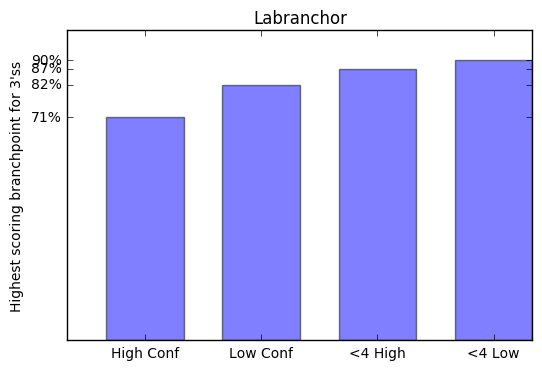

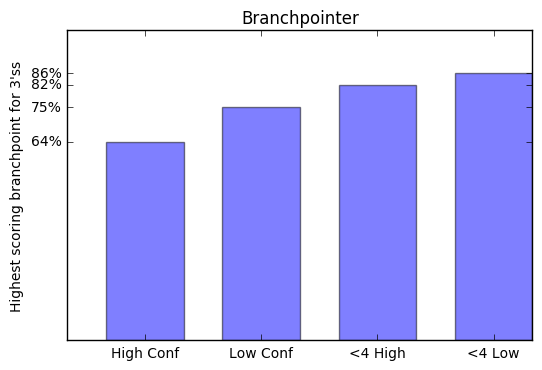

0.000618663650838
0.000369873233093
0.00349321915769
0.0075244371842


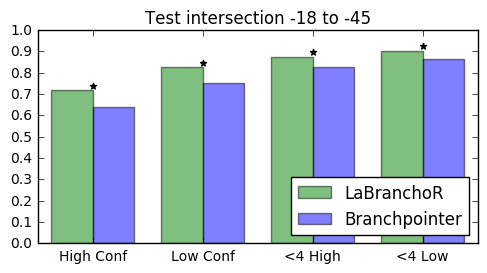

Totals
742 742
LaBranchoR
[0.7196765498652291, 0.8247978436657682, 0.876010781671159, 0.9043126684636119]
branchpointer
[0.6401617250673854, 0.7520215633423181, 0.8247978436657682, 0.862533692722372]


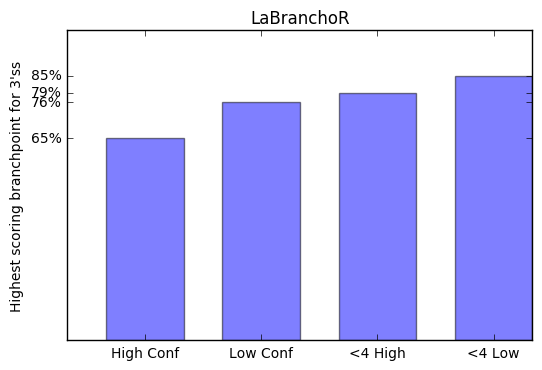

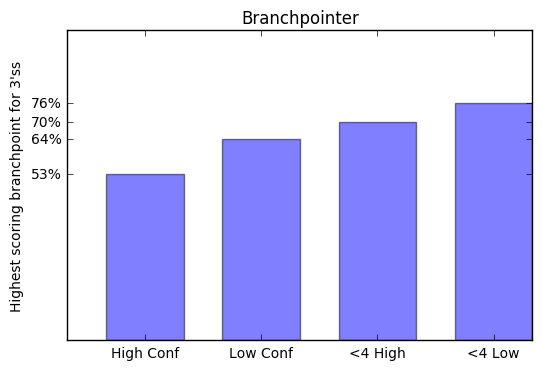

2.76360442501e-07
2.5566067967e-08
2.40207002396e-06
1.08036092664e-06


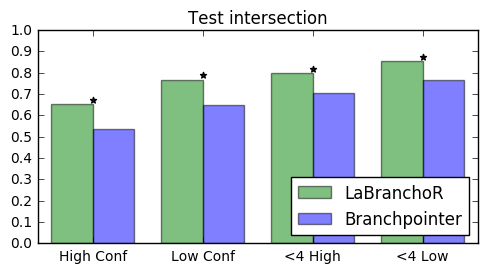

Totals
887 887
LaBranchoR
[0.6527621195039459, 0.7677564825253664, 0.7993235625704622, 0.85456595264938]
branchpointer
[0.5355129650507328, 0.649379932356257, 0.7046223224351748, 0.7655016910935738]


In [37]:
from scipy.stats import fisher_exact
labels = ['High Conf','Low Conf','<4 High','<4 Low']

L = 27
lstm_t, lstm_h = shifted_matching(lstm[mask, -45:-18], y_filt[mask, -45:-18], 'Labranchor')
bptr_t, bptr_h = shifted_matching(bptr[mask, -45:-18], y_filt[mask, -45:-18], 'Branchpointer')
assert lstm_t == bptr_t

performance(lstm_h, bptr_h, [lstm_t]*4, labels, 'Test intersection -18 to -45')

print 'Totals'
print lstm_t, bptr_t
print 'LaBranchoR'
print lstm_h
print 'branchpointer'
print bptr_h

L = 70
lstm_t, lstm_h = shifted_matching(lstm[mask], y_filt[mask], 'LaBranchoR')
bptr_t, bptr_h = shifted_matching(bptr[mask], y_filt[mask], 'Branchpointer')

performance(lstm_h, bptr_h, [lstm_t]*4, labels, 'Test intersection')

print 'Totals'
print lstm_t, bptr_t
print 'LaBranchoR'
print lstm_h
print 'branchpointer'
print bptr_h

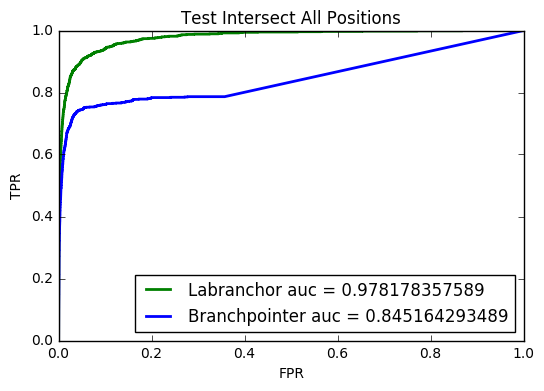

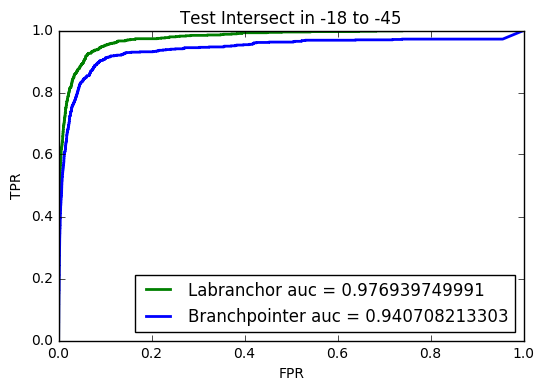

In [43]:
def bptr_roc(y, bptr, lstm, title):
    bptr = bptr[np.max(y, axis = 1)>0].flatten()
    lstm = lstm[np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             lstm[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                lstm[y != -1])
    plt.plot(fpr, tpr, label = "Labranchor auc = {}".format(auc), lw = 2, c = 'g')

    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             bptr[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                bptr[y != -1])
    plt.plot(fpr, tpr, label = "Branchpointer auc = {}".format(auc), lw = 2, c = 'b')

    plt.legend(loc = 4)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

bptr_roc(y_filt[mask], bptr[mask], lstm[mask], 'Test Intersect All Positions')
bptr_roc(y_filt[mask, -45:-18], bptr[mask, -45:-18], lstm[mask, -45:-18], 'Test Intersect in -18 to -45')

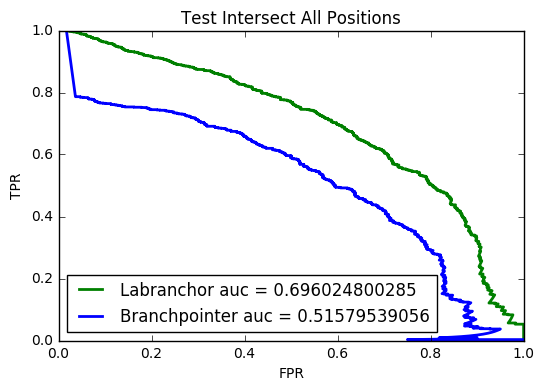

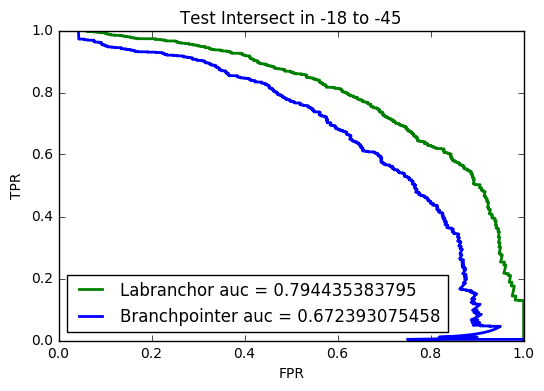

In [41]:
def bptr_prc(y, bptr, lstm, title):
    bptr = bptr[np.max(y, axis = 1)>0].flatten()
    lstm = lstm[np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    fpr, tpr, _ = metrics.precision_recall_curve(y[y != -1],
                                                 lstm[y != -1],
                                                 pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                          lstm[y != -1])
    plt.plot(fpr, tpr, label = "Labranchor auc = {}".format(auc), lw = 2, c = 'g')

    fpr, tpr, _ = metrics.precision_recall_curve(y[y != -1],
                                                 bptr[y != -1],
                                                 pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                          bptr[y != -1])
    plt.plot(fpr, tpr, label = "Branchpointer auc = {}".format(auc), lw = 2, c = 'b')
    plt.legend(loc = 3)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

bptr_prc(y_filt[mask], bptr[mask], lstm[mask], 'Test Intersect All Positions')
bptr_prc(y_filt[mask, -45:-18], bptr[mask, -45:-18], lstm[mask, -45:-18], 'Test Intersect in -18 to -45')

(887,) (887,)


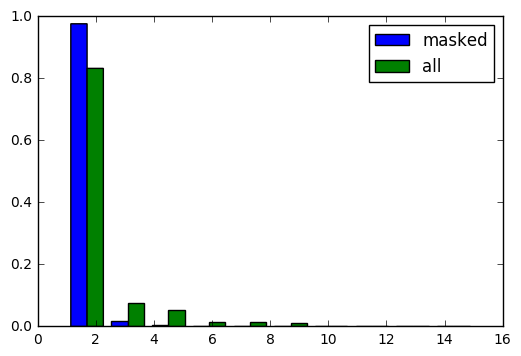

In [44]:
w1 = np.ones_like(np.sum(y_filt[mask]==1, axis = 1)) / float(y_filt[mask].shape[0])
w2 = np.ones_like(np.sum(y_filt==1, axis = 1)) / float(y_filt.shape[0])
print w1.shape, np.sum(y_filt[mask]==1, axis = 1).shape
plt.hist([np.sum(y_filt[mask]==1, axis = 1), np.sum(y_filt==1, axis = 1)],
         weights = [w1, w2], label = ['masked', 'all'])
plt.legend()
plt.show()